# 숙명여자대학교 딥러닝 2024 (Assignment 2)

# 과제2: CNN & Transfer Learning - 실습보고서 작성

- 각 실습 과제의 목표 및 목적
- 실습 과제의 진행 과정 구체적인 숫자 포함
- 실습 과제 결과
- 생각해볼 점, 논의할 점, 이외에 본인이 기록하고 싶은 모든 것 가능
- 전체적으로 필요시 학습 속도 (Learning Curve)와 모델의 Training 및 Inference 시간, 파라미터의 수를 비교하세요.


#(채점 기준)
1. 각 문제의 목표 및 목적을 명시하였는 가?
2. 핵심코드가 모두 있으면서 결과를 첨부하였는 가?
3. 아래 논의사항이 포함되었는 가?


# 실습 과제 1. Lab 3 CNN MNIST 실습에서 Dropout 을 추가하기 전과 후의 모델을 각각 학습시키고 결과를 논의하세요.

## 목표: Dropout이 학습에 미치는 영향과 모델의 일반화 성능 향상, overfitting 방지 효과를 확인한다.

### 논의사항
- Dropout 추가시 Training Loss가 더 천천히 떨어지고 Training Accuracy는 더 빨리 올라간다.
- Test Accuracy는 비슷한 수준이지만 근소한 차이로 Dropout을 사용시 더 높은 경향을 보인다.
- 충분히 학습시 Dropout을 사용하지 않으면 overfitting이 발생하면서 Test Accuracy가 떨어진다.
- 이러한 경향은 Traininig Data를 더 적게하였을 때 쉽게 확인할 수 있다.
아래와 같이 Training Data를 0.1%만 사용했을 때 (총 60개의 데이터 사용해서 학습, 5% Test 데이터를 사용) Dropout을 사용시 더 높은 정확도를 보이는 것을 확인할 수 있다.

- 예를들어, Maximum Test accuracy는
 - Dropout 사용시: 72.6% at epoch 69
 - Dropout 사용않을때: 66.0 at epoch 14



- 다른 Dropout 관련 실험을 수행한 경우 가산점

### Train with 0.1% training data

num_train 60000 num_test 10000
Epoch 1: Train Loss = 2.2967, Train Accuracy = 11.67%, Test Accuracy = 10.00%
Epoch 2: Train Loss = 2.2071, Train Accuracy = 16.67%, Test Accuracy = 35.40%
Epoch 3: Train Loss = 2.0444, Train Accuracy = 33.33%, Test Accuracy = 43.40%
Epoch 4: Train Loss = 1.8731, Train Accuracy = 40.00%, Test Accuracy = 45.40%
Epoch 5: Train Loss = 1.6791, Train Accuracy = 58.33%, Test Accuracy = 46.00%
Epoch 6: Train Loss = 1.5400, Train Accuracy = 55.00%, Test Accuracy = 46.80%
Epoch 7: Train Loss = 1.4000, Train Accuracy = 70.00%, Test Accuracy = 49.60%
Epoch 8: Train Loss = 1.1939, Train Accuracy = 71.67%, Test Accuracy = 51.60%
Epoch 9: Train Loss = 0.9188, Train Accuracy = 85.00%, Test Accuracy = 51.80%
Epoch 10: Train Loss = 0.8269, Train Accuracy = 85.00%, Test Accuracy = 55.40%
Epoch 11: Train Loss = 0.6787, Train Accuracy = 83.33%, Test Accuracy = 56.80%
Epoch 12: Train Loss = 0.5522, Train Accuracy = 86.67%, Test Accuracy = 57.80%
Epoch 13: Train Loss = 0.6005,

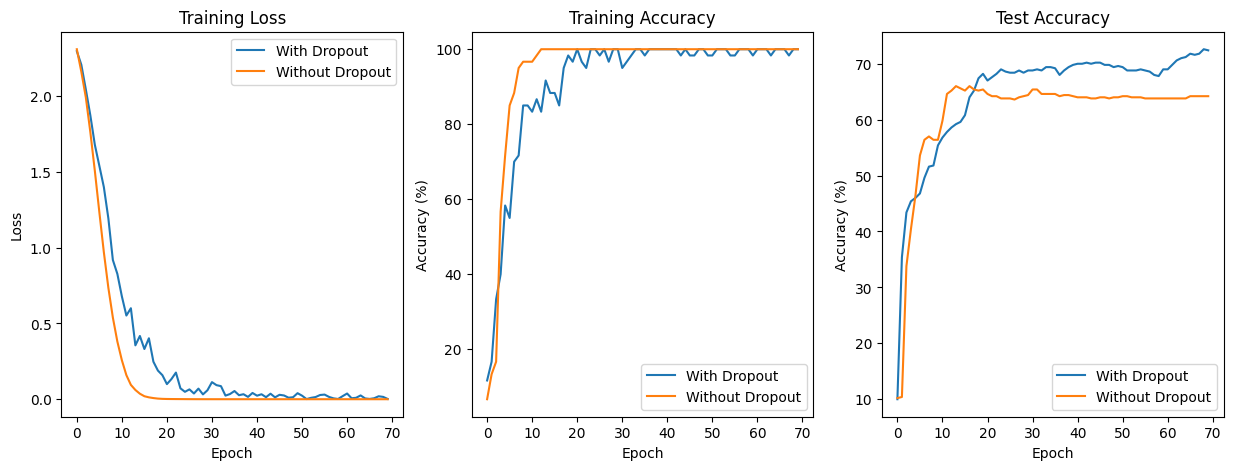

In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Step 1: Define the transformations and load the MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset_full = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True, transform=transform)
# Reduce the training set to 10%
num_train = len(trainset_full)
indices = list(range(num_train))
np.random.shuffle(indices)
subset_indices = indices[:int(0.001 * num_train)]
trainset = Subset(trainset_full, subset_indices)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset_full = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
num_test = len(testset_full)
indices = list(range(num_test))
np.random.shuffle(indices)
subset_indices = indices[:int(0.05 * num_test)]
testset = Subset(testset_full, subset_indices)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print('num_train', num_train, 'num_test', num_test)
# Step 2: Define the CNN architecture with and without dropout
class NetWithDropout(nn.Module):
    def __init__(self):
        super(NetWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

class NetWithoutDropout(nn.Module):
    def __init__(self):
        super(NetWithoutDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

# Instantiate networks
net_with_dropout = NetWithDropout()
net_without_dropout = NetWithoutDropout()

# Step 3: Define a Loss function and Optimizer, and Train
def train_and_evaluate(model, optimizer, trainloader, testloader, epochs=70):
    criterion = nn.CrossEntropyLoss()
    training_losses = []
    training_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        training_losses.append(running_loss / len(trainloader))
        training_accuracies.append(100 * correct / total)

        # Evaluate on test data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracies.append(100 * correct / total)
        print(f'Epoch {epoch + 1}: Train Loss = {running_loss / len(trainloader):.4f}, Train Accuracy = {training_accuracies[-1]:.2f}%, Test Accuracy = {100 * correct / total:.2f}%')

    return training_losses, training_accuracies, test_accuracies

optimizer_with = optim.Adam(net_with_dropout.parameters(), lr=0.001)
optimizer_without = optim.Adam(net_without_dropout.parameters(), lr=0.001)

loss_with, acc_train_with, acc_test_with = train_and_evaluate(net_with_dropout, optimizer_with, trainloader, testloader)
loss_without, acc_train_without, acc_test_without = train_and_evaluate(net_without_dropout, optimizer_without, trainloader, testloader)

# Plot the learning curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(loss_with, label='With Dropout')
plt.plot(loss_without, label='Without Dropout')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(acc_train_with, label='With Dropout')
plt.plot(acc_train_without, label='Without Dropout')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(acc_test_with, label='With Dropout')
plt.plot(acc_test_without, label='Without Dropout')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


### Print the maximum test accuracy for both models

In [33]:
print('Maximum test accuracy without dropout:', max(acc_test_without), 'at epoch', acc_test_without.index(max(acc_test_without)) + 1)
print('Maximum test accuracy with dropout:', max(acc_test_with), 'at epoch', acc_test_with.index(max(acc_test_with)) + 1)

Maximum test accuracy without dropout: 66.0 at epoch 14
Maximum test accuracy with dropout: 72.6 at epoch 69


In [22]:
# prompt: Show all the training labels of the 60 training images

trainloader = DataLoader(trainset, batch_size=60, shuffle=True)
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Print the labels of the first 60 training images
print(labels)

tensor([4, 2, 7, 8, 2, 9, 2, 0, 7, 6, 3, 4, 5, 4, 5, 1, 2, 8, 6, 8, 9, 0, 1, 2,
        0, 1, 9, 8, 9, 7, 8, 7, 2, 8, 7, 7, 3, 5, 8, 0, 4, 3, 3, 6, 5, 3, 6, 0,
        6, 1, 5, 8, 8, 9, 3, 3, 5, 0, 5, 7])


### Count each labels for the reduced training data

In [23]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([6, 4, 6, 7, 4, 7, 5, 7, 9, 5]))

 ### Show the results by images from the net with dropout and without dropout

With Dropout


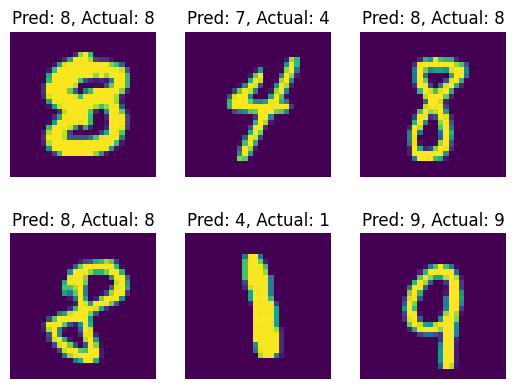

Without Dropout


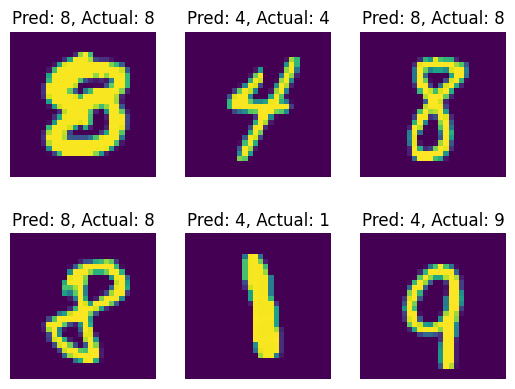

In [40]:
# prompt: Show the results by images from the net with dropout and without dropout

# Display some images and their predicted labels
def imshow(img):
    # Convert the image to a numpy array and transpose it
    img = img.numpy().transpose((1, 2, 0))
    # Rescale the image to be between 0 and 1
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    # Display the image
    plt.imshow(img)
    #plt.show()

# Get some random images from the test set
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show the images with their predicted labels
net_with_dropout.eval()
outputs = net_with_dropout(images)
_, predicted = torch.max(outputs, 1)

print('With Dropout')
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i])
    plt.title(f"Pred: {predicted[i].item()}, Actual: {labels[i].item()}")
    plt.axis('off')
plt.show()


# Show the images with their predicted labels
net_without_dropout.eval()
outputs = net_without_dropout(images)
_, predicted = torch.max(outputs, 1)

print('Without Dropout')
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i])
    plt.title(f"Pred: {predicted[i].item()}, Actual: {labels[i].item()}")
    plt.axis('off')
plt.show()


# 실습 과제 2, 3 GAP, Batch Norm 비교
# 실습 과제 2 Lab 3 CNN MNIST 실습에서 데이터셋을 CIFAR10으로 바꾸고 Global Average Pooling를 추가하기 전과 후 모델을 각각 수정하여 약 1M 개의 파라미터로 학습시키고 비교하여 결과를 논의하세요.

### 목표2: GAP를 사용한 모델이 Flatten을 사용한 모델보다 높은 성능을 보이는 것을 확인한다.

# 실습 과제 3. 위 실습 과제 2, GAP를 추가한 모델에서 BatchNorm을 추가하기 전과 후를 각각 학습시키고 결과를 논의하세요.

### 목표3: Batch Normalization을 사용하면 학습속도가 빠르다는 것을 확인한다.

### 논의사항
- GAP가 없는 모델은 GAP 모델보다 더 빠르게 학습되지만 최종 테스트, Validation 성능은 GAP 모델이 더 높다.
- BN을 사용하면 모델이 학습될 때 노이즈가 커지지만 학습 속도는 더 빠르다.
(추가 실험 생각해볼 내용)
- BN을 사용하면 learning rate를 증가시킬 수 있다.
- BN을 사용하면 layer를 더 깊게 쌓을 수 있다.

## CNN CIFAR10 with or without GAP

Files already downloaded and verified
Files already downloaded and verified
GAP_Net Total Parameters: 1072.138 k
NoGAP_Net Total Parameters: 1023.802 k
Training GAP_Net
Epoch 1 - Train Loss: 1.727, Train Acc: 33.46%, Val Loss: 1.447, Val Acc: 45.82%
Epoch 2 - Train Loss: 1.296, Train Acc: 52.34%, Val Loss: 1.212, Val Acc: 55.38%
Epoch 3 - Train Loss: 1.072, Train Acc: 61.56%, Val Loss: 1.031, Val Acc: 63.10%
Epoch 4 - Train Loss: 0.938, Train Acc: 66.58%, Val Loss: 0.922, Val Acc: 67.24%
Epoch 5 - Train Loss: 0.830, Train Acc: 70.59%, Val Loss: 0.773, Val Acc: 72.66%
Epoch 6 - Train Loss: 0.746, Train Acc: 73.54%, Val Loss: 0.747, Val Acc: 73.94%
Epoch 7 - Train Loss: 0.677, Train Acc: 76.31%, Val Loss: 0.744, Val Acc: 73.80%
Epoch 8 - Train Loss: 0.612, Train Acc: 78.53%, Val Loss: 0.670, Val Acc: 76.08%
Epoch 9 - Train Loss: 0.562, Train Acc: 80.04%, Val Loss: 0.624, Val Acc: 78.90%
Epoch 10 - Train Loss: 0.511, Train Acc: 81.94%, Val Loss: 0.619, Val Acc: 78.32%
Epoch 11 - Train Los

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1 - Train Loss: 1.635, Train Acc: 40.17%, Val Loss: 1.224, Val Acc: 55.94%
Epoch 2 - Train Loss: 1.346, Train Acc: 51.48%, Val Loss: 1.120, Val Acc: 60.20%
Epoch 3 - Train Loss: 1.227, Train Acc: 56.28%, Val Loss: 1.038, Val Acc: 64.86%
Epoch 4 - Train Loss: 1.146, Train Acc: 59.27%, Val Loss: 0.994, Val Acc: 65.68%
Epoch 5 - Train Loss: 1.084, Train Acc: 61.66%, Val Loss: 0.947, Val Acc: 66.84%
Epoch 6 - Train Loss: 1.036, Train Acc: 63.26%, Val Loss: 0.917, Val Acc: 67.24%
Epoch 7 - Train Loss: 0.999, Train Acc: 64.59%, Val Loss: 0.903, Val Acc: 68.06%
Epoch 8 - Train Loss: 0.962, Train Acc: 65.63%, Val Loss: 0.902, Val Acc: 68.34%
Epoch 9 - Train Loss: 0.934, Train Acc: 66.61%, Val Loss: 0.896, Val Acc: 68.26%
Epoch 10 - Train Loss: 0.892, Train Acc: 67.80%, Val Loss: 0.890, Val Acc: 68.80%
Epoch 11 - Train Loss: 0.873, Train Acc: 68.68%, Val Loss: 0.890, Val Acc: 69.02%
Epoch 12 - Train Loss: 0.845, Train Acc: 69.65%, Val Loss: 0.899, Val Acc: 68.26%
Epoch 13 - Train Loss: 0.

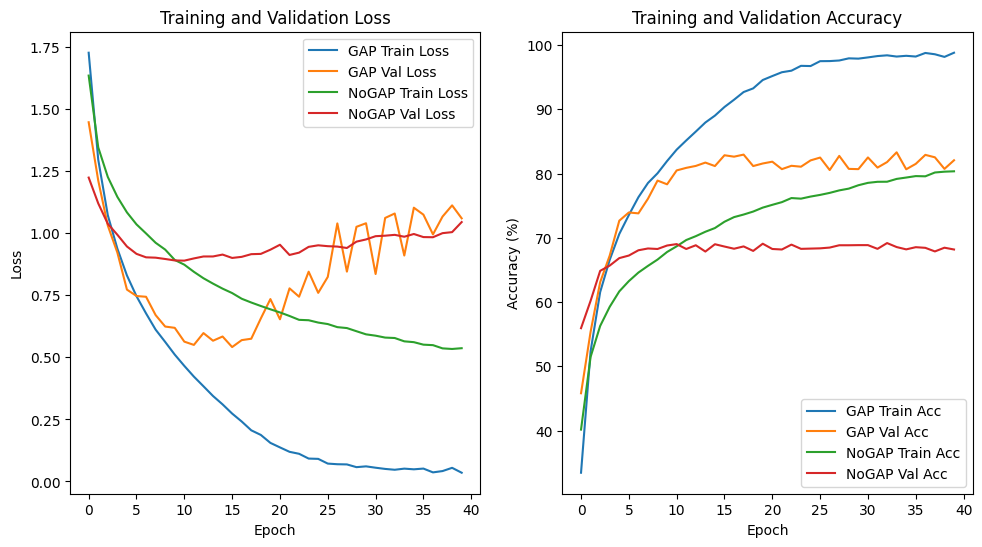

GAP_Net Accuracy of the network on the 10,000 test images: 81.51%
NoGAP_Net Accuracy of the network on the 10,000 test images: 67.48%


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, SubsetRandomSampler

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Stratified split setup
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = trainset.targets
for train_index, val_index in sss.split(np.zeros(len(targets)), targets):
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Define the CNN architectures
class GAP_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Define the CNN architectures
class NoGAP_Net(nn.Module):
    def __init__(self):
        super(NoGAP_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 80)
        self.fc2 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)


# Function to train and evaluate models
def train_and_evaluate(model, optimizer, trainloader, valloader, testloader, device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(40):
        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(100 * correct / total)

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch+1} - Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_accuracies[-1]:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Train and Evaluate GAP_Net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gap_net = GAP_Net().to(device)
nogap_net = NoGAP_Net().to(device)

# prompt: count the total number of learnable parameters
total_params = sum(p.numel() for p in gap_net.parameters())
print(f"GAP_Net Total Parameters: {total_params/1000} k")
total_params = sum(p.numel() for p in nogap_net.parameters())
print(f"NoGAP_Net Total Parameters: {total_params/1000} k")


optimizer_gap = optim.Adam(gap_net.parameters(), lr=0.001)
optimizer_nogap = optim.Adam(nogap_net.parameters(), lr=0.001)

print("Training GAP_Net")
train_loss_gap, train_acc_gap, val_loss_gap, val_acc_gap = train_and_evaluate(gap_net, optimizer_gap, trainloader, valloader, testloader, device)
print("Training NoGAP_Net")
train_loss_nogap, train_acc_nogap, val_loss_nogap, val_acc_nogap = train_and_evaluate(nogap_net, optimizer_nogap, trainloader, valloader, testloader, device)
print('Finished Training')


# Plot results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(train_loss_gap, label='GAP Train Loss')
plt.plot(val_loss_gap, label='GAP Val Loss')
plt.plot(train_loss_nogap, label='NoGAP Train Loss')
plt.plot(val_loss_nogap, label='NoGAP Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_acc_gap, label='GAP Train Acc')
plt.plot(val_acc_gap, label='GAP Val Acc')
plt.plot(train_acc_nogap, label='NoGAP Train Acc')
plt.plot(val_acc_nogap, label='NoGAP Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


# Step 6: Evaluate the network on the test data
correct = 0
total = 0
gap_net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = gap_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'GAP_Net Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

correct = 0
total = 0
nogap_net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = nogap_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'NoGAP_Net Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')


## CNN CIFAR10 GAP with or without Batch Normalization

Files already downloaded and verified
Files already downloaded and verified
GAP_BN_Net_Net Total Parameters: 1072.138 k
NoGAP_Net Total Parameters: 1023.802 k
Training GAP_BN_Net
Epoch 1 - Train Loss: 1.294, Train Acc: 52.48%, Val Loss: 1.244, Val Acc: 56.48%
Epoch 2 - Train Loss: 0.936, Train Acc: 66.57%, Val Loss: 1.201, Val Acc: 58.74%
Epoch 3 - Train Loss: 0.784, Train Acc: 72.35%, Val Loss: 1.023, Val Acc: 66.24%
Epoch 4 - Train Loss: 0.671, Train Acc: 76.36%, Val Loss: 0.750, Val Acc: 74.02%
Epoch 5 - Train Loss: 0.590, Train Acc: 79.30%, Val Loss: 0.766, Val Acc: 74.02%
Epoch 6 - Train Loss: 0.513, Train Acc: 82.12%, Val Loss: 1.009, Val Acc: 67.80%
Epoch 7 - Train Loss: 0.451, Train Acc: 84.48%, Val Loss: 0.776, Val Acc: 74.66%
Epoch 8 - Train Loss: 0.389, Train Acc: 86.39%, Val Loss: 0.654, Val Acc: 78.34%
Epoch 9 - Train Loss: 0.335, Train Acc: 88.33%, Val Loss: 0.875, Val Acc: 74.80%
Epoch 10 - Train Loss: 0.299, Train Acc: 89.63%, Val Loss: 0.796, Val Acc: 75.80%
Epoch 11 -

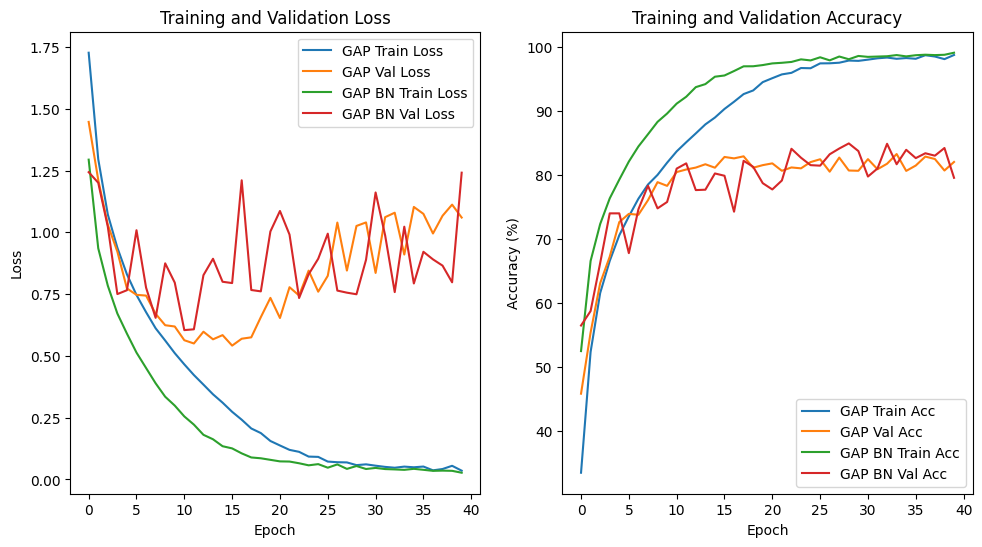

GAP_BN_Net Accuracy of the network on the 10,000 test images: 78.26%


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, SubsetRandomSampler

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the dataset into training and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = trainset.targets
for train_index, val_index in sss.split(np.zeros(len(targets)), targets):
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Define the CNN architectures
class GAP_BN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Define the CNN architectures
class NoGAP_Net(nn.Module):
    def __init__(self):
        super(NoGAP_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 80)
        self.fc2 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)


# Function to train and evaluate models
def train_and_evaluate(model, optimizer, trainloader, valloader, testloader, device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(40):
        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(100 * correct / total)

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch+1} - Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_accuracies[-1]:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Train and Evaluate GAP_Net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gap_bn_net = GAP_BN_Net().to(device)

# prompt: count the total number of learnable parameters
total_params = sum(p.numel() for p in gap_bn_net.parameters())
print(f"GAP_BN_Net_Net Total Parameters: {total_params/1000} k")
total_params = sum(p.numel() for p in nogap_net.parameters())
print(f"NoGAP_Net Total Parameters: {total_params/1000} k")


optimizer_gap_bn = optim.Adam(gap_bn_net.parameters(), lr=0.001)
optimizer_nogap = optim.Adam(nogap_net.parameters(), lr=0.001)

print("Training GAP_BN_Net")
train_loss_gap_bn, train_acc_gap_bn, val_loss_gap_bn, val_acc_gap_bn = train_and_evaluate(gap_bn_net, optimizer_gap_bn, trainloader, valloader, testloader, device)
print('Finished Training')

# Plot results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(train_loss_gap, label='GAP Train Loss')
plt.plot(val_loss_gap, label='GAP Val Loss')
plt.plot(train_loss_gap_bn, label='GAP BN Train Loss')
plt.plot(val_loss_gap_bn, label='GAP BN Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_acc_gap, label='GAP Train Acc')
plt.plot(val_acc_gap, label='GAP Val Acc')
plt.plot(train_acc_gap_bn, label='GAP BN Train Acc')
plt.plot(val_acc_gap_bn, label='GAP BN Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


# Step 6: Evaluate the network on the test data
correct = 0
total = 0
gap_bn_net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = gap_bn_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'GAP_BN_Net Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')


Save all the history data and models for GAP, NoGAP, GAP_BN

In [ ]:
# prompt: save all the history data and models for GAP, NoGAP, GAP_BN

# Save the trained models
torch.save(gap_net.state_dict(), "gap_net.pt")
torch.save(nogap_net.state_dict(), "nogap_net.pt")
torch.save(gap_bn_net.state_dict(), "gap_bn_net.pt")

# Save the history data
import pickle

with open("history.pkl", "wb") as f:
    pickle.dump([train_loss_gap, train_acc_gap, val_loss_gap, val_acc_gap, train_loss_nogap, train_acc_nogap, val_loss_nogap, val_acc_nogap, train_loss_gap_bn, train_acc_gap_bn, val_loss_gap_bn, val_acc_gap_bn], f)


# 실습 과제 4. Lab 3 Transfer Learning

## 실습에서 ResNet18의 (i) learnable parameters을 고정한 경우와 (ii) 마지막 3개 Layer만 제외하고 나머지 learnable parameters를 고정한 경우, (iii) 모든 레이어를 고정하지 않은 경우에 대해 학습시키고 결과를 논의하세요.

# 목표: 전체 레이어를 fine-tuning하면 성능이 높아질 수 있으나 데이터가 적은 경우 불리함을 확인한다. 또한, 일부 레이어를 고정하지 않고 모델을 수정할 수 있다.

## 논의사항
- 모두 fix하지 않고 학습시키면 가장 성능이 높다.
- 마지막 일부 레이어를 trainable하게 하면 성능이 미소하게 상승한다.

(추가로 실험 생각해볼 내용)
- MNIST 예제 처럼 데이터를 적게 선별하여 학습시키면 (예, training data의 0.1%만 사용하고, validation data 역시 0.5%만 사용) fine tuning 모델이 overfitting이 일어난다.

## ResNet18 Net_All_Fixed

100%|██████████| 170498071/170498071 [00:03<00:00, 55196454.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 43.4MB/s]


Epoch 1, Batch 200, Loss: 1.191, Accuracy: 63.43%
Epoch 1, Batch 400, Loss: 0.756, Accuracy: 75.49%
Epoch 1, Batch 600, Loss: 0.691, Accuracy: 76.83%
Epoch 1 - Training Loss: 0.847, Accuracy: 77.52%, Validation Loss: 0.633, Accuracy: 78.42%
Epoch 2, Batch 200, Loss: 0.631, Accuracy: 78.70%
Epoch 2, Batch 400, Loss: 0.624, Accuracy: 78.27%
Epoch 2, Batch 600, Loss: 0.619, Accuracy: 78.76%
Epoch 2 - Training Loss: 0.626, Accuracy: 78.67%, Validation Loss: 0.580, Accuracy: 79.70%
Epoch 3, Batch 200, Loss: 0.615, Accuracy: 79.09%
Epoch 3, Batch 400, Loss: 0.583, Accuracy: 79.77%
Epoch 3, Batch 600, Loss: 0.584, Accuracy: 79.63%
Epoch 3 - Training Loss: 0.594, Accuracy: 78.68%, Validation Loss: 0.577, Accuracy: 79.92%
Epoch 4, Batch 200, Loss: 0.581, Accuracy: 79.52%
Epoch 4, Batch 400, Loss: 0.581, Accuracy: 80.05%
Epoch 4, Batch 600, Loss: 0.575, Accuracy: 80.05%
Epoch 4 - Training Loss: 0.580, Accuracy: 79.48%, Validation Loss: 0.555, Accuracy: 80.72%
Epoch 5, Batch 200, Loss: 0.564, Acc

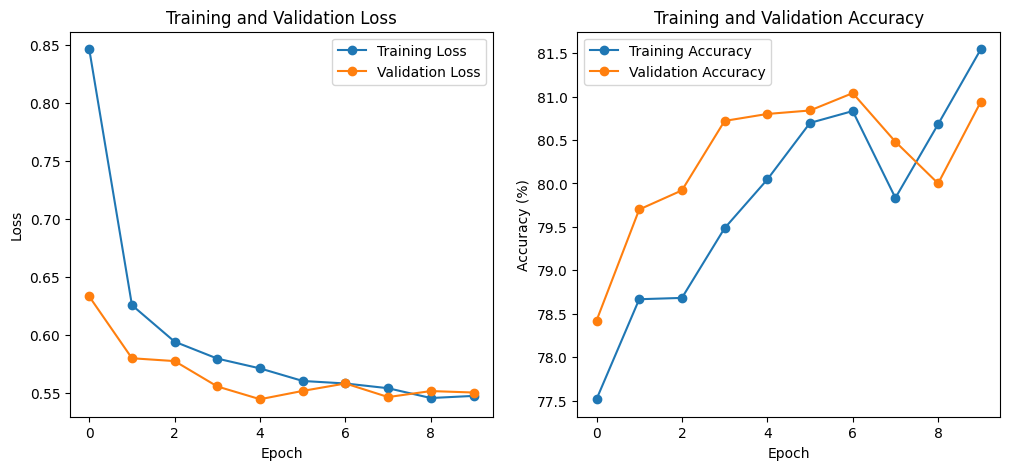

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to fit ResNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for 3 channels
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Same stratified split setup
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = trainset.targets
for train_index, val_index in sss.split(np.zeros(len(targets)), targets):
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


# Step 2: Define the CNN architecture with pretrained resnet18
class Net_All_Fixed(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet and modify it
        self.resnet = models.resnet18(pretrained=True)

        # Freeze all the layers in the network
        for param in self.resnet.parameters():
            param.requires_grad = False

        # CIFAR-10 has 10 classes, modify the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)  # Adjust for 10 classes

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_all_fixed = Net_All_Fixed().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_all_fixed = optim.Adam(net_all_fixed.parameters(), lr=0.001)

# Function to train and evaluate a model
def train_and_evaluate(net, optimizer, epochs=10):
  train_losses = []
  train_accuracy = []
  train_losses_iter = []
  train_accuracy_iter = []
  val_losses = []
  val_accuracy = []

  for epoch in range(epochs):
      running_loss_iter = 0.0
      running_loss = 0.0
      correct = 0
      total = 0
      net.train()
      for i, data in enumerate(trainloader):
          inputs, labels = data[0].to(device), data[1].to(device)

          optimizer.zero_grad()

          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          running_loss_iter += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          if i % 200 == 199:  # print and record every 200 mini-batches
              avg_loss = running_loss_iter / 200
              accuracy = 100 * correct / total
              print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
              train_losses_iter.append(avg_loss)
              train_accuracy_iter.append(accuracy)
              running_loss_iter = 0.0
              correct = 0
              total = 0

      train_losses.append(running_loss / len(trainloader))
      train_accuracy.append(100 * correct / total)

      # Validation step
      net.eval()
      val_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
          for data in valloader:
              inputs, labels = data[0].to(device), data[1].to(device)
              outputs = net(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      val_losses.append(val_loss / len(valloader))
      val_accuracy.append(100 * correct / total)

      print(f'Epoch {epoch+1} - Training Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy[-1]:.2f}%, Validation Loss: {val_losses[-1]:.3f}, Accuracy: {val_accuracy[-1]:.2f}%')

  print('Finished Training')
  return train_losses, train_accuracy, val_losses, val_accuracy

# Train the network
train_loss_all_fixed, train_acc_all_fixed, val_loss_all_fixed, val_acc_all_fixed = \
 train_and_evaluate(net_all_fixed, optimizer_all_fixed)

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
net_all_fixed.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_all_fixed(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all_fixed, '-o',label='Training Loss')
plt.plot(val_loss_all_fixed, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all_fixed,  '-o',label='Training Accuracy')
plt.plot(val_acc_all_fixed, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()



## ResNet18 Net_All_Fixed (Training 2nd)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 200, Loss: 1.185, Accuracy: 63.55%
Epoch 1, Batch 400, Loss: 0.765, Accuracy: 74.91%
Epoch 1, Batch 600, Loss: 0.686, Accuracy: 77.06%
Epoch 1 - Training Loss: 0.849, Accuracy: 76.76%, Validation Loss: 0.629, Accuracy: 78.92%
Epoch 2, Batch 200, Loss: 0.631, Accuracy: 78.51%
Epoch 2, Batch 400, Loss: 0.627, Accuracy: 78.07%
Epoch 2, Batch 600, Loss: 0.624, Accuracy: 78.60%
Epoch 2 - Training Loss: 0.624, Accuracy: 79.39%, Validation Loss: 0.593, Accuracy: 79.68%
Epoch 3, Batch 200, Loss: 0.582, Accuracy: 79.74%
Epoch 3, Batch 400, Loss: 0.605, Accuracy: 79.19%
Epoch 3, Batch 600, Loss: 0.586, Accuracy: 79.66%
Epoch 3 - Training Loss: 0.593, Accuracy: 79.62%, Validation Loss: 0.560, Accuracy: 80.44%
Epoch 4, Batch 200, Loss: 0.583, Accuracy: 80.00%
Epoch 4, Batch 400, Loss: 0.594, Accuracy: 78.93%
Epoch 4, Batch 600, Loss: 0.571, Accuracy: 80.17%
Epoch 4 - Training Loss: 0.581, Accuracy: 79.89%, Validation Loss: 0.558, Accuracy: 80.84%
Epoch 5, Batch 200, Loss: 0.561, Acc

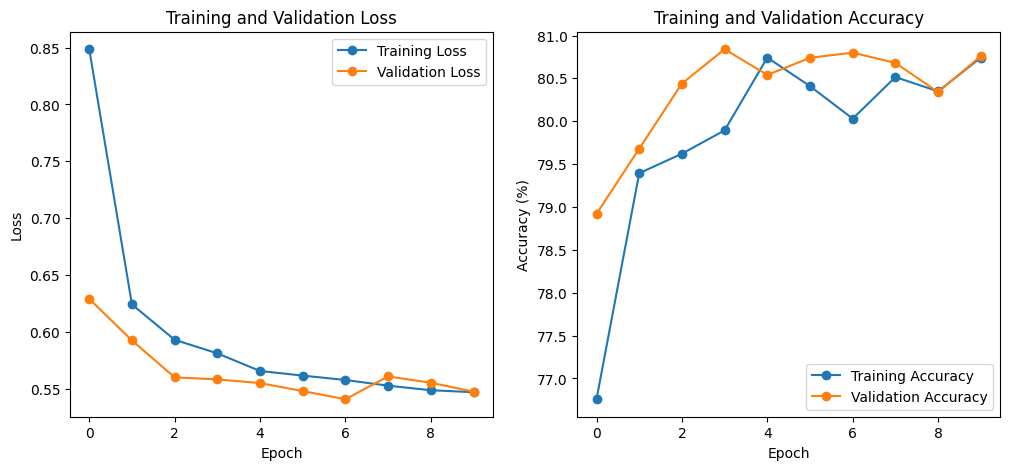

In [10]:
# Same as above

## ResNet18 Net_Not_Fixed

Epoch 1, Batch 200, Loss: 0.763, Accuracy: 73.80%
Epoch 1, Batch 400, Loss: 0.537, Accuracy: 81.52%
Epoch 1, Batch 600, Loss: 0.472, Accuracy: 83.84%
Epoch 1 - Training Loss: 0.568, Accuracy: 84.83%, Validation Loss: 0.488, Accuracy: 83.52%
Epoch 2, Batch 200, Loss: 0.339, Accuracy: 88.48%
Epoch 2, Batch 400, Loss: 0.330, Accuracy: 88.92%
Epoch 2, Batch 600, Loss: 0.330, Accuracy: 88.60%
Epoch 2 - Training Loss: 0.330, Accuracy: 89.09%, Validation Loss: 0.355, Accuracy: 87.88%
Epoch 3, Batch 200, Loss: 0.199, Accuracy: 93.26%
Epoch 3, Batch 400, Loss: 0.236, Accuracy: 91.78%
Epoch 3, Batch 600, Loss: 0.243, Accuracy: 91.68%
Epoch 3 - Training Loss: 0.229, Accuracy: 91.74%, Validation Loss: 0.425, Accuracy: 86.60%
Epoch 4, Batch 200, Loss: 0.131, Accuracy: 95.32%
Epoch 4, Batch 400, Loss: 0.185, Accuracy: 93.58%
Epoch 4, Batch 600, Loss: 0.182, Accuracy: 93.54%
Epoch 4 - Training Loss: 0.166, Accuracy: 94.55%, Validation Loss: 0.358, Accuracy: 89.02%
Epoch 5, Batch 200, Loss: 0.101, Acc

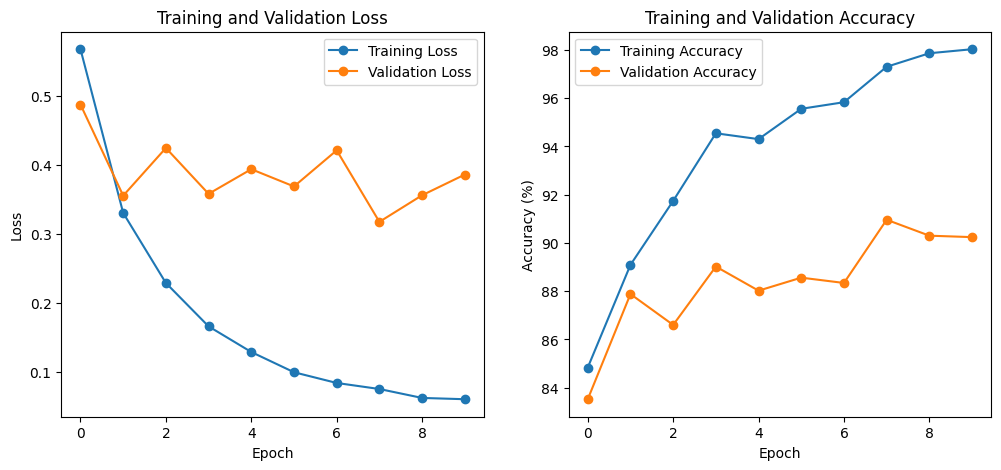

In [4]:
# Step 2: Define the CNN architecture with pretrained resnet18
class Net_Not_Fixed(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet and modify it
        self.resnet = models.resnet18(pretrained=True)

        # Freeze all the layers in the network
        for param in self.resnet.parameters():
            param.requires_grad = True

        # CIFAR-10 has 10 classes, modify the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)  # Adjust for 10 classes

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_not_fixed = Net_Not_Fixed().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_not_fixed = optim.Adam(net_not_fixed.parameters(), lr=0.001)

# Train the network
train_loss_not_fixed, train_acc_not_fixed, val_loss_not_fixed, val_acc_not_fixed = \
 train_and_evaluate(net_not_fixed, optimizer_not_fixed)

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
net_not_fixed.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_not_fixed(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_not_fixed, '-o',label='Training Loss')
plt.plot(val_loss_not_fixed, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_not_fixed,  '-o',label='Training Accuracy')
plt.plot(val_acc_not_fixed, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()



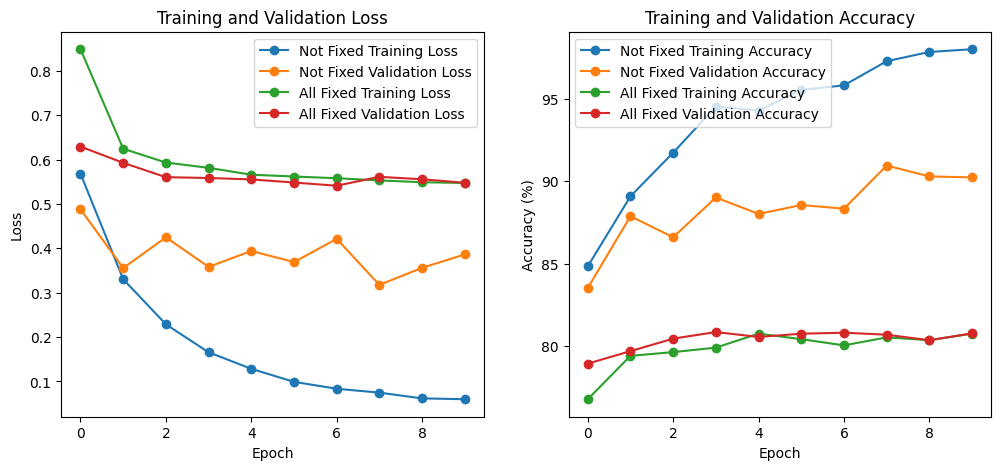

In [13]:
# prompt: 2 plots to compare train_loss_not_fixed, val_loss_not_fixed, train_acc_not_fixed, val_acc_not_fixed, train_loss_all_fixed, train_acc_all_fixed, val_loss_all_fixed, val_acc_all_fixed

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_not_fixed, '-o',label='Not Fixed Training Loss')
plt.plot(val_loss_not_fixed, '-o', label='Not Fixed Validation Loss')
plt.plot(train_loss_all_fixed, '-o',label='All Fixed Training Loss')
plt.plot(val_loss_all_fixed, '-o', label='All Fixed Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_not_fixed,  '-o',label='Not Fixed Training Accuracy')
plt.plot(val_acc_not_fixed, '-o', label='Not Fixed Validation Accuracy')
plt.plot(train_acc_all_fixed,  '-o',label='All Fixed Training Accuracy')
plt.plot(val_acc_all_fixed, '-o', label='All Fixed Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


## ResNet18 Fixed Except the Last 3 Layers

Epoch 1, Batch 200, Loss: 0.764, Accuracy: 73.40%
Epoch 1, Batch 400, Loss: 0.543, Accuracy: 81.30%
Epoch 1, Batch 600, Loss: 0.469, Accuracy: 84.20%
Epoch 1 - Training Loss: 0.570, Accuracy: 85.30%, Validation Loss: 0.484, Accuracy: 83.66%
Epoch 2, Batch 200, Loss: 0.366, Accuracy: 87.48%
Epoch 2, Batch 400, Loss: 0.326, Accuracy: 88.90%
Epoch 2, Batch 600, Loss: 0.334, Accuracy: 88.52%
Epoch 2 - Training Loss: 0.338, Accuracy: 89.32%, Validation Loss: 0.404, Accuracy: 86.76%
Epoch 3, Batch 200, Loss: 0.215, Accuracy: 92.67%
Epoch 3, Batch 400, Loss: 0.229, Accuracy: 92.20%
Epoch 3, Batch 600, Loss: 0.242, Accuracy: 91.52%
Epoch 3 - Training Loss: 0.229, Accuracy: 92.12%, Validation Loss: 0.308, Accuracy: 89.40%
Epoch 4, Batch 200, Loss: 0.136, Accuracy: 95.29%
Epoch 4, Batch 400, Loss: 0.170, Accuracy: 93.93%
Epoch 4, Batch 600, Loss: 0.182, Accuracy: 93.72%
Epoch 4 - Training Loss: 0.167, Accuracy: 93.38%, Validation Loss: 0.314, Accuracy: 90.18%
Epoch 5, Batch 200, Loss: 0.118, Acc

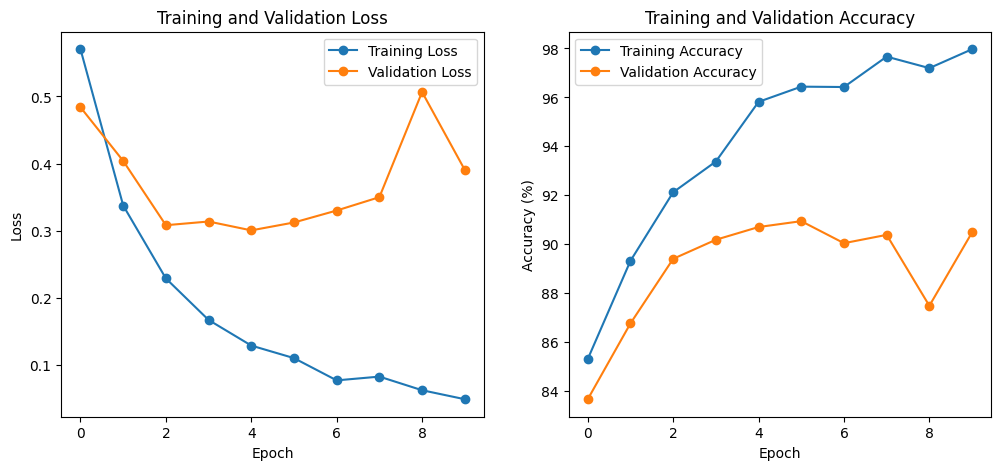

In [11]:
# Step 2: Define the CNN architecture with pretrained resnet18
class Net_Ex3_Fixed(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet and modify it
        self.resnet = models.resnet18(pretrained=True)

        # Freeze all the layers in the network
        for param in self.resnet.parameters():
            param.requires_grad = True

        for param in net_all_fixed.resnet.layer4[0].conv2.parameters():
          param.requires_grad = False

        for param in net_all_fixed.resnet.layer4[1].parameters():
          param.requires_grad = False

        # CIFAR-10 has 10 classes, modify the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)  # Adjust for 10 classes

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_ex3_fixed = Net_Ex3_Fixed().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ex3_fixed = optim.Adam(net_ex3_fixed.parameters(), lr=0.001)

# Train the network
train_loss_gap_ex3_fixed, train_acc_ex3_fixed, val_loss_ex3_fixed, val_acc_ex3_fixed = \
 train_and_evaluate(net_ex3_fixed, optimizer_ex3_fixed)

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
net_ex3_fixed.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_ex3_fixed(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_gap_ex3_fixed, '-o',label='Training Loss')
plt.plot(val_loss_ex3_fixed, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_ex3_fixed,  '-o',label='Training Accuracy')
plt.plot(val_acc_ex3_fixed, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()



In [12]:
# prompt: save train_loss_not_fixed, val_loss_not_fixed, train_acc_not_fixed, val_acc_not_fixed, train_loss_all_fixed, train_acc_all_fixed, val_loss_all_fixed, val_acc_all_fixed, train_loss_gap_ex3_fixed, train_acc_ex3_fixed, val_loss_ex3_fixed, val_acc_ex3_fixed

import pickle

# Save the training and validation loss and accuracy for all three networks
with open('training_results.pkl', 'wb') as f:
  pickle.dump([train_loss_not_fixed, val_loss_not_fixed, train_acc_not_fixed, val_acc_not_fixed,
              train_loss_all_fixed, train_acc_all_fixed, val_loss_all_fixed, val_acc_all_fixed,
              train_loss_gap_ex3_fixed, train_acc_ex3_fixed, val_loss_ex3_fixed, val_acc_ex3_fixed], f)


In [15]:
# prompt: Save the models net_ex3_fixed, net_not_fixed, net_all_fixed

torch.save(net_ex3_fixed.state_dict(), "net_ex3_fixed.pt")
torch.save(net_not_fixed.state_dict(), "net_not_fixed.pt")
torch.save(net_all_fixed.state_dict(), "net_all_fixed.pt")

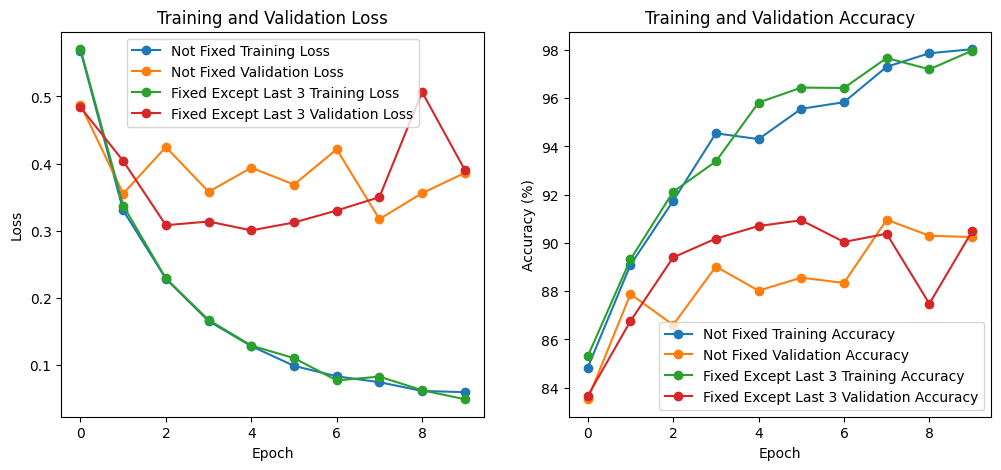

In [16]:
# prompt: 2 plots to compare train_loss_not_fixed, train_acc_not_fixed, val_loss_not_fixed, val_acc_not_fixed, train_loss_gap_ex3_fixed, train_acc_ex3_fixed, val_loss_ex3_fixed, val_acc_ex3_fixed

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_not_fixed, '-o',label='Not Fixed Training Loss')
plt.plot(val_loss_not_fixed, '-o', label='Not Fixed Validation Loss')
plt.plot(train_loss_gap_ex3_fixed, '-o',label='Fixed Except Last 3 Training Loss')
plt.plot(val_loss_ex3_fixed, '-o', label='Fixed Except Last 3 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_not_fixed,  '-o',label='Not Fixed Training Accuracy')
plt.plot(val_acc_not_fixed, '-o', label='Not Fixed Validation Accuracy')
plt.plot(train_acc_ex3_fixed,  '-o',label='Fixed Except Last 3 Training Accuracy')
plt.plot(val_acc_ex3_fixed, '-o', label='Fixed Except Last 3 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


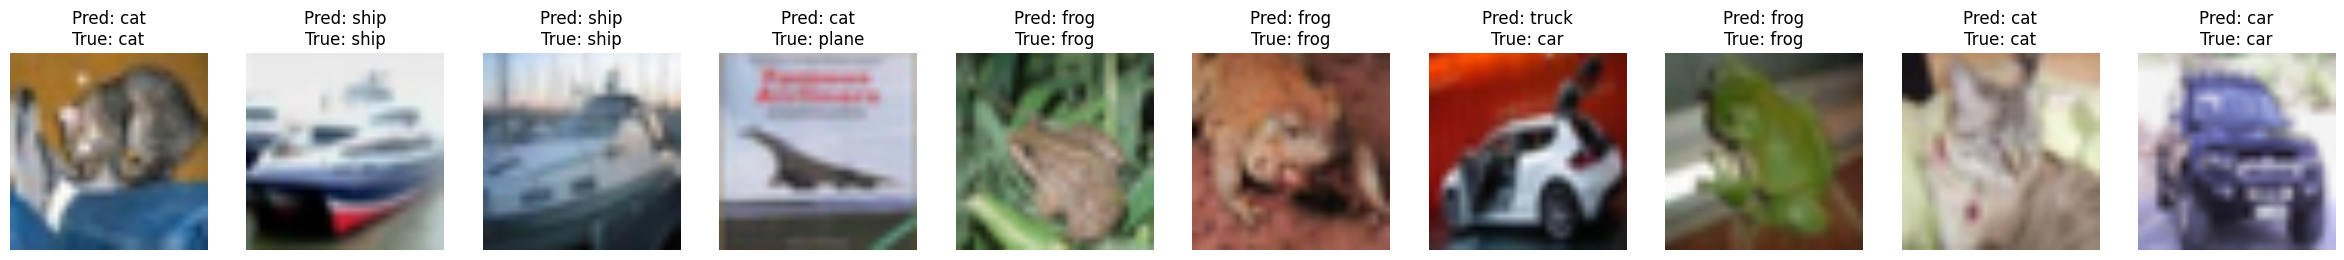

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(images, labels, predicted_labels):
    """Function to display images with labels and predictions"""
    # Set number of images to display
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    for idx in range(num_images):
        ax = axes[idx]
        img = images[idx] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.axis('off')
        # Set title with predicted and true labels
        ax.set_title(f'Pred: {classes[predicted_labels[idx]]}\nTrue: {classes[labels[idx]]}')

# Load a batch of images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict labels
predicted_outputs = net(images.to(device))
_, predicted = torch.max(predicted_outputs, 1)

# Show images with annotations
imshow(images[:10], labels[:10], predicted[:10])
plt.show()


Predicted:  cat   ship  ship  cat   frog 
True:       cat   ship  ship  plane frog 


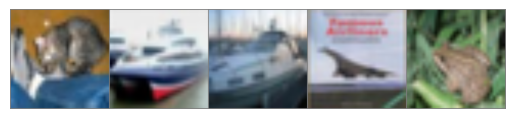

In [18]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:5]))
# Print labels
predicted_outputs = net(images.to(device))
_, predicted = torch.max(predicted_outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(5)))
print('True:      ', ' '.join(f'{classes[labels[j]]:5s}'
                              for j in range(5)))

plt.show()
